In [64]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from itertools import product, chain
import importlib

import trainer, data, models

In [153]:
importlib.reload(trainer)
importlib.reload(data)
importlib.reload(models)

<module 'models' from '/Users/ralph/projects/d2dl/models.py'>

In [154]:
kaggle_housing_dataset = data.kaggle_housing()

In [171]:
kaggle_housing_dataset.train.dataframe.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1125,0.938392,-0.872563,-4.564744e-01,-0.008301,-1.518467,-0.517200,-0.538802,-1.447101,-0.574410,-0.973018,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
342,-0.919411,0.782828,6.454645e-16,-0.197721,-2.241782,-1.416142,-0.737526,-1.689368,1.309170,-0.973018,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
173,-1.320392,-0.872563,4.519361e-01,-0.032054,-0.071836,-0.517200,-0.340077,-1.156380,2.145702,-0.341359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
946,0.513684,0.546344,-2.269135e-03,-0.235905,-0.795151,0.381743,-0.406319,-1.253287,0.134702,0.667542,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
389,-0.807895,0.073375,1.178664e+00,0.196152,2.821425,-0.517200,1.183477,1.120936,0.932454,1.834357,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [157]:
class LinearRegression(nn.Sequential):
    def __init__(self, hidden_dim: int = 100, num_outputs: int = 1):
        super().__init__(
            nn.LazyLinear(hidden_dim),
            nn.ReLU(),
            nn.LazyLinear(num_outputs)
        )

In [158]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [159]:
provider = lambda hyperparams: trainer.Trainer(
    model=LinearRegression(hidden_dim=hyperparams.model["hidden_dim"], num_outputs=1),
    dataset=kaggle_housing_dataset,
    loss=RMSLELoss,
    opt=torch.optim.SGD,
    hyperparameters=hyperparams
)

In [160]:
model_trainer = provider(trainer.Hyperparameters(
    opt=dict(
        lr = 1e-3
    ),
    model=dict(
        hidden_dim = 100
    ),
    general=dict(
        num_epochs = 200,
        batch_size = 6
    )
))

/Users/ralph/.venvs/d2dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [161]:
train_result = model_trainer.train(16)

In [164]:
train_result

,train,val
0,12.105652,12.068521
1,12.123299,11.687802
2,11.762332,12.103120
3,11.765411,11.837670
4,11.574232,12.102566
...,...,...
995,7.744671,7.617826
996,7.702687,7.616677
997,7.864686,7.651832
998,7.726078,7.552651


<Axes: >

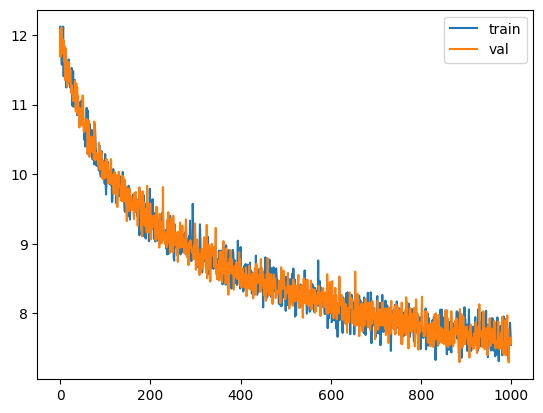

In [163]:
train_result.plot()

In [165]:
val_x = torch.stack([
    kaggle_housing_dataset.val[i][0]
    for i in range(len(kaggle_housing_dataset.val))
])

In [166]:
val_y = torch.stack([
    kaggle_housing_dataset.val[i][1]
    for i in range(len(kaggle_housing_dataset.val))
])

In [172]:
model_y = model_trainer.model(val_x)

In [168]:
val_df = pd.DataFrame(
    torch.stack([
        torch.flatten(model_y.detach()),
        torch.flatten(val_y)
    ], dim = 1),
    columns=["pred", "val"]
)

<Axes: xlabel='pred', ylabel='val'>

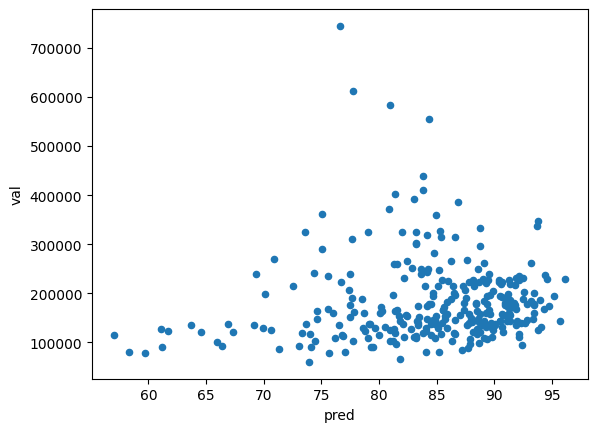

In [169]:
val_df.plot(kind="scatter", x="pred", y="val")